# NN rruff DataBase For Powder Difraction X-Ray

### Creating the tensor DataSet and Labels

In [249]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [250]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [251]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/ML_rruff'
os.chdir(data_dir)

# List the contents of the directory
print(os.listdir())

print("------------")

os.chdir('XY_Processed')
dirs = os.listdir()
print(dirs)

['XY_Processed', 'EX1', 'Selected', 'DataSet.ipynb', 'NN_Pro.ipynb', 'NN_Pro2.ipynb', 'NN.ipynb', 'Tensors']
------------
['Diamond__R050207-9__Powder__Xray_Data_XY_Processed__7229.txt', 'Diaoyudaoite__R050182-9__Powder__Xray_Data_XY_Processed__6935.txt', 'Diaphorite__R060173-9__Powder__Xray_Data_XY_Processed__2352.txt', 'Diaspore__R060546-1__Powder__Xray_Data_XY_Processed__3677.txt', 'Diaspore__R060287-1__Powder__Xray_Data_XY_Processed__2783.txt', 'Dickite__R060298-1__Powder__Xray_Data_XY_Processed__2779.txt', 'Dickite__R090054-1__Powder__Xray_Data_XY_Processed__10128.txt', 'Dietrichite__R070381-1__Powder__Xray_Data_XY_Processed__8417.txt', 'Digenite__R060840-1__Powder__Xray_Data_XY_Processed__6871.txt', 'Diopside__R040009-1__Powder__Xray_Data_XY_Processed__2567.txt', 'Diopside__R040097-1__Powder__Xray_Data_XY_Processed__3420.txt', 'Diopside__R050406-1__Powder__Xray_Data_XY_Processed__5733.txt', 'Diopside__R050496-1__Powder__Xray_Data_XY_Processed__1811.txt', 'Diopside__R050666-1__Pow

In [252]:
# Get Data Function

def get_data(file_path):
    # Read the data from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the data points
    data = []
    metadata = []
    for line in lines:
        if line.startswith('##'):
            metadata.append(line.strip())
        else:
            try:
                x, y = map(float, line.strip().split(','))
                data.append((x, y))
            except ValueError:
                #print(f"Warning: Skipping invalid data: '{line.strip()}'")
                pass

    if not data:
        print("Error: No valid data points found in the file.")
        return


    #print(x_values)

    # Separate x and y values
    x_values, y_values = zip(*data)
    return x_values, y_values

x_values, y = get_data(dirs[0])
print(len(x_values))



8501


In [201]:
# Creating more Examples for eatch Sample by adding noise and X-shift

def create_noise(file_path, n=5, intensity_noise=0.04, peak_shift=1, peak_threshold=0.5):
    x_values, y_values = get_data(file_path)
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Identify peaks
    peaks, _ = find_peaks(y_values, height=peak_threshold * np.max(y_values), distance=1)

    noisy_data = []

    for _ in range(n):
        # Create peak shifts
        shifts = np.random.uniform(-peak_shift, peak_shift, size=len(peaks))
        shift_array = np.zeros_like(x_values)
        shift_array[peaks] = shifts

        # Smooth out shifts for neighboring points
        kernel = np.array([0.5, 1, 0.5])
        smoothed_shifts = np.convolve(shift_array, kernel, mode='same') / np.sum(kernel)

        noisy_x = x_values + smoothed_shifts

        # Add intensity noise
        noise = np.random.uniform(-intensity_noise * np.max(y_values),
                                  intensity_noise * np.max(y_values),
                                  size=len(y_values))
        noisy_y = np.maximum(0, y_values + noise)

        # Sort the data points based on x values to maintain order
        sorted_indices = np.argsort(noisy_x)
        noisy_x = noisy_x[sorted_indices]
        noisy_y = noisy_y[sorted_indices]

        noisy_data.append((noisy_x, noisy_y))

    return noisy_data



In [219]:
# Creating the DataPoints and Getting all Files from / to the Tensor

def Create_DataPoint(file_path, n):
    x_values, y_values = get_data(file_path)

    if len(x_values) != 8501:
        return None, None  # Return None if the file doesn't have 8501 data points

    # Extract the molecule name from the filename
    filename = os.path.basename(file_path)
    label = filename.split('__')[0]  # Get the part before the first '__'

    # Generate noisy data
    noisy_data = create_noise(file_path, n)

    # Combine original and noisy data
    labels = [label]*(n+1)
    all_y = [np.array(y_values)]
    for _, noisy_y in noisy_data:
        all_y.append(np.array(noisy_y))

    # Convert to tensor
    y_tensor = torch.from_numpy(np.array(all_y)).float()

    return y_tensor, labels


def process_all_files_in_directory(n=5):
    data_tensor = None
    all_labels = []

    # Get the current working directory
    directory_path = os.getcwd()

    # Get all files with .txt extension in the current directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]

    for file_name in txt_files:
        file_path = os.path.join(directory_path, file_name)
        y_tensor, labels = Create_DataPoint(file_path, n)

        if y_tensor is not None:
            # Add data to the main tensor
            if data_tensor is None:
                data_tensor = y_tensor
            else:
                data_tensor = torch.cat((data_tensor, y_tensor), dim=0)

            all_labels.extend(labels)

    return data_tensor, all_labels

# Usage
data_tensor, labels = process_all_files_in_directory(n=5)



In [222]:
print(f"Final data tensor shape: {data_tensor.shape}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {len(set(labels))}")
output_p = (list(set(labels)))
print(output_p)

Final data tensor shape: torch.Size([7692, 8501])
Number of labels: 7692
Unique labels: 756
['Cubiczirconia', 'Beraunite', 'Schneiderhohnite', 'Sekaninaite', 'ArrojaditeKNa', 'Ferroedenite', 'PhillipsiteCa', 'PumpellyiteMg', 'Bikitaite', 'Eakerite', 'Stibnite', 'Petzite', 'Scheelite', 'Sassolite', 'Tiemannite', 'Despujolsite', 'Metatorbernite', 'Kovdorskite', 'Leiteite', 'Marialite', 'Proustite', 'Teallite', 'Polydymite', 'Eglestonite', 'PyrosmaliteFe', 'Creedite', 'Scorodite', 'Portlandite', 'FerrieriteMg', 'Dietrichite', 'Ilvaite', 'Gyrolite', 'Monticellite', 'Adamite', 'Liebigite', 'BastnasiteCe', 'Metarossite', 'Langite', 'Zwieselite', 'Zoisite', 'Nickeline', 'Kornerupine', 'Dyscrasite', 'Natrojarosite', 'Plombierite', 'Pyrope', 'Akermanite', 'Sylvite', 'StillwelliteCe', 'Carnotite', 'Chalcanthite', 'Amblygonite', 'Phlogopite', 'Phoenicochroite', 'Hydroxylapatite', 'Caryochroite', 'Perroudite', 'Schorlomite', 'Reedmergnerite', 'Chalcophanite', 'Elbaite', 'Fairfieldite', 'Legrandite

In [229]:
# Saving the tensor
torch.save(data_tensor, 'data_tensor.pt')
torch.save(labels, 'labels.pt')



In [273]:
!ls
#os.chdir('..')

data_tensor.pt	labels.pt  Parameters


In [253]:


"""
try:
  os.chdir('..')
  print("------------")
  os.chdir('Tensors')
  dirs = os.listdir()
  print(dirs)
except:
  pass

"""

------------
['data_tensor.pt', 'labels.pt', 'Parameters']
7692
7692


In [276]:

"""
# Loading the tensor later
data_tensor = torch.load('data_tensor.pt')
labels = torch.load('labels.pt')

print(len(data_tensor))
print(len(labels))
"""

7692
7692


-------------
Diamond


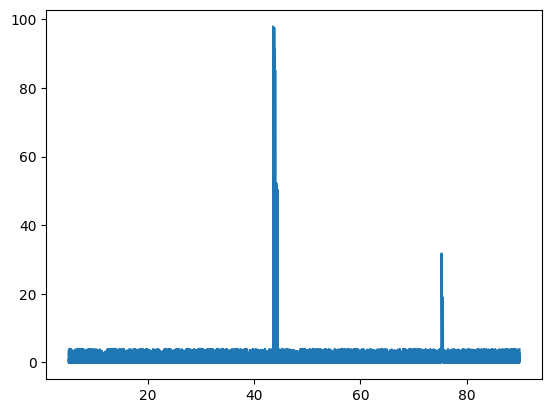

In [277]:
# Plotting an Example

plt.plot(x_values, data_tensor[1])
print("-------------")
print(labels[1])

#--------------------------------------------
# Creating the NN

In [278]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [279]:

import torch
import torch.nn.functional as F

def prepare_labels_for_cross_entropy(labels, all_labels):
    # Create a dictionary mapping each unique label to a unique integer
    label_to_index = {label: idx for idx, label in enumerate(set(all_labels))}

    # Convert labels to their corresponding integers
    label_indices = [label_to_index[label] for label in labels]

    # Convert to tensor
    label_indices_tensor = torch.tensor(label_indices, dtype=torch.long)

    # Create one-hot encoded tensor
    num_classes = len(label_to_index)
    one_hot_labels = F.one_hot(label_indices_tensor, num_classes=num_classes)

    return one_hot_labels, label_indices_tensor, label_to_index

# Usage
#Alredy run...
#data_tensor, labels = process_all_files_in_directory(n=5)
unique_labels = list(set(labels))
one_hot_labels, label_indices, label_to_index = prepare_labels_for_cross_entropy(labels, unique_labels)

print(f"One-hot labels shape: {one_hot_labels.shape}")
print(f"Label indices shape: {label_indices.shape}")
print(f"Unique Labels: {len(label_to_index)}")




One-hot labels shape: torch.Size([7692, 756])
Label indices shape: torch.Size([7692])
Unique Labels: 756


In [280]:
print(one_hot_labels[0])
print(label_indices.shape)
print(label_to_index)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [281]:
# Assuming data_tensor shape is [7692, 8501] and label_indices is a tensor or list of length 7692

# Step 1: Create a permutation
num_samples = data_tensor.shape[0]
perm = torch.randperm(num_samples)

# Step 2: Shuffle both data_tensor and label_indices
shuffled_data_tensor = data_tensor[perm]
if isinstance(label_indices, torch.Tensor):
    shuffled_label_indices = label_indices[perm]
else:
    shuffled_label_indices = [label_indices[i] for i in perm.tolist()]

# Step 3: Keep only the first 100 cases for kept_data and its labels
num_keep = 100
kept_data = shuffled_data_tensor[:num_keep]
kept_labels = shuffled_label_indices[:num_keep]

# Step 4: Remove the first 100 cases from data_tensor and label_indices
data_tensor = shuffled_data_tensor[num_keep:]
label_indices = shuffled_label_indices[num_keep:]

# Print shapes to verify
print("Shape of data_tensor (shuffled - 100 cases):", data_tensor.shape)
print("Length of label_indices (shuffled - 100 cases):", len(label_indices))
print("Shape of kept_data (100 cases):", kept_data.shape)
print("Length of kept_labels (100 cases):", len(kept_labels))


Shape of data_tensor (shuffled - 100 cases): torch.Size([7592, 8501])
Length of label_indices (shuffled - 100 cases): 7592
Shape of kept_data (100 cases): torch.Size([100, 8501])
Length of kept_labels (100 cases): 100


In [282]:
class NN(torch.nn.Module):
    def __init__(self, label_to_index):
        super().__init__()
        self.g = torch.Generator().manual_seed(2147483647)

        self.W1 = torch.nn.Parameter(torch.randn((8501, 800), generator=self.g))
        self.b1 = torch.nn.Parameter(torch.randn(800, generator=self.g))
        self.W2 = torch.nn.Parameter(torch.randn((800, len(label_to_index)), generator=self.g))
        self.b2 = torch.nn.Parameter(torch.randn(len(label_to_index), generator=self.g))

        print(f"The NN has: {sum(p.numel() for p in self.parameters())} parameters")

    def forward(self, data_tensor, label_indices):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        probabilities = F.softmax(logits, dim=1)

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(logits, label_indices)

        return loss

    def __call__(self, data_tensor):
        h = torch.tanh(data_tensor @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        probabilities = F.softmax(logits, dim=0)

        return probabilities

nn_model = NN(label_to_index)
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.1)

nn_model = nn_model.to('cuda')
data_tensor = data_tensor.to('cuda')
label_indices = label_indices.to('cuda')


The NN has: 7407156 parameters


In [283]:
loss = nn_model.forward(data_tensor, label_indices)
print(f"The initial loss is: {loss}")
print(f"We have {len(data_tensor)} Examples.")

The initial loss is: 90.06336975097656
We have 7592 Examples.


In [284]:
while True:
    optimizer.zero_grad()
    loss = nn_model.forward(data_tensor, label_indices)
    loss.backward()

    print(f"The loss is: {loss}")
    optimizer.step()


    if loss.item() < 1e-3:
        print("Reached Stop Point!!")
        break



Streaming output truncated to the last 5000 lines.
The loss is: 0.02365071140229702
The loss is: 0.023613709956407547
The loss is: 0.023588309064507484
The loss is: 0.02356424741446972
The loss is: 0.02354089729487896
The loss is: 0.02351691946387291
The loss is: 0.023495569825172424
The loss is: 0.02347375638782978
The loss is: 0.023456847295165062
The loss is: 0.023419173434376717
The loss is: 0.023395512253046036
The loss is: 0.02337076887488365
The loss is: 0.023346826434135437
The loss is: 0.023323753848671913
The loss is: 0.02329888939857483
The loss is: 0.0232757106423378
The loss is: 0.023253977298736572
The loss is: 0.023234421387314796
The loss is: 0.023207835853099823
The loss is: 0.02319224737584591
The loss is: 0.02315622754395008
The loss is: 0.023134203627705574
The loss is: 0.023113420233130455
The loss is: 0.02309647761285305
The loss is: 0.023061668500304222
The loss is: 0.023040542379021645
The loss is: 0.023018475621938705
The loss is: 0.023002756759524345
The loss 

KeyboardInterrupt: 

In [240]:
"""
try:
  print("------------")
  os.chdir('Parameters')
  dirs = os.listdir()
  print(dirs)
except:
  pass


torch.save(nn_model.W1, 'W1.pt')
torch.save(nn_model.W2, 'W2.pt')
torch.save(nn_model.b1, 'b1.pt')
torch.save(nn_model.b2, 'b2.pt')



"""

------------


In [261]:
!ls

data_tensor.pt	labels.pt  Parameters


In [262]:

"""
try:
  os.chdir('Parameters')
  print("------------")
  !ls
except:
  pass


nn_model.W1 = torch.load('W1.pt')
nn_model.W2 = torch.load('W2.pt')
nn_model.b1 = torch.load('b1.pt')
nn_model.b2 = torch.load('b2.pt')

"""


------------
b1.pt  b2.pt  W1.pt  W2.pt


Expected label:  Weddellite
Predicted label: Clinohumite
Probability: 0.9991


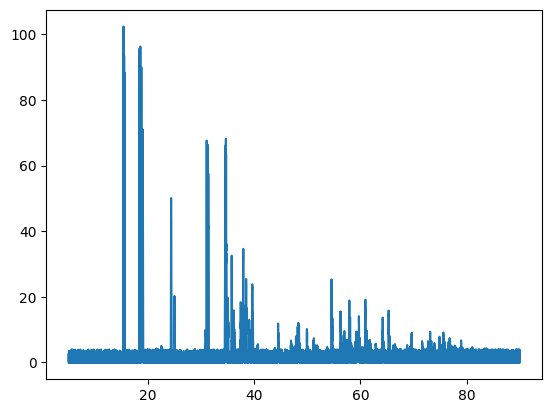

100


In [285]:

index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the dictionary
def test_example(data_tensor, i, p_info=True):

  probabilities = nn_model(data_tensor[i])

  max_prob_index = torch.argmax(probabilities).item()

  predicted_label = index_to_label[max_prob_index]
  if p_info == True:
    #print(data_tensor[i])
    print(f"Expected label:  {index_to_label[label_indices[i].item()]}")
    print(f"Predicted label: {predicted_label}")
    print(f"Probability: {probabilities[max_prob_index].item():.4f}")

    plt.plot(x_values, data_tensor[10].cpu())
    plt.show()


  return probabilities[max_prob_index].item(), index_to_label[label_indices[i].item()] == predicted_label

kept_data = kept_data.to('cuda')
test_example(kept_data, 2)
print(len(kept_data))

In [286]:
print(f"Size of Test Batch: {len(kept_data)}")
probs = []
for i in range(len(data_tensor)):
  result, correct = test_example(kept_data, i, False)
  if correct == False:
    print(i)
  probs.append(result)

print(sum(probs) / len(probs))

Size of Test Batch: 100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IndexError: index 100 is out of bounds for dimension 0 with size 100